# Eligiendo el número de clusters para k-means

## El método del codo

Cargamos las librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans

Generamos un dataset y lo mostramos

In [2]:
dataset = np.array([[1.5,1.5],[1.2,1.5],[1.7,1.6],[1.9,1.3],[1.4,1.6],[1.4,1.2],[1.3,1.3],
            [1.5,4.5],[1.2,5.5],[1.7,5.6],[1.9,4.3],[1.4,5.6],[1.4,4.2],[1.3,4.3],
           [3.5, 1.5], [3.2, 1.5], [3.7, 1.6], [3.9, 1.3], [3.4, 1.6], [3.4, 1.2], [3.3, 1.3],
           [5.5, 5.5], [5.2, 5.5], [5.7, 5.6], [5.9, 5.3], [5.4, 5.6], [5.4, 5.2], [5.3, 5.3]])

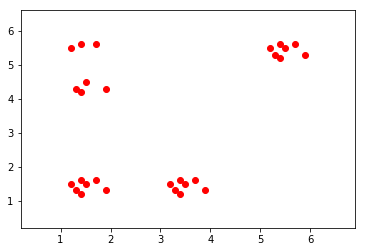

In [3]:
plt.plot(dataset[:,0],dataset[:,1],'ro')
plt.axis([dataset[:,0].min()-1,dataset[:,0].max()+1,dataset[:,1].min()-1,dataset[:,1].max()+1])
plt.show()

Generamos los costes de los resultados obtenidos usando K-means con distinto número de clústeres.

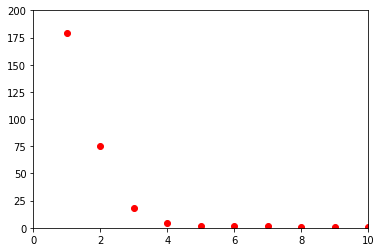

In [4]:
costs = []
for i in range(1,11):
    est = KMeans(n_clusters=i)
    est.fit(dataset)
    costs.append(est.inertia_)

plt.plot(range(1,11),costs,'ro')
plt.axis([0,10,0,200])
plt.show()

La figura muestra que con k=5 se obtiene el resultado buscado. Veámos a continuación la distribución de puntos con esos clústeres.

In [5]:
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))

est = KMeans(n_clusters=5)
est.fit(dataset)
Z = est.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Generamos el gráfico

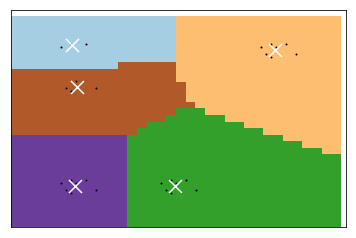

In [6]:
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(dataset[:, 0], dataset[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = est.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## El método de las siluetas

Al igual que antes comenzamos cargando las librerías necesarias

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

Vamos a generar las siluetas para el rango de clústeres de 2 a 7

In [8]:
range_n_clusters = range(2,8)

Generamos los diagramas utilizando la siguiente función que toma el dataset y el número de clústeres. Se generan dos figuras, a la izquierda el gráfico de siluetas y a la derecha la distribución de clústeres

In [13]:
def grafico_silueta(dataset,n_clusters):
        X = dataset
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        

Vemos el resultado para los distintos valores de k.

For n_clusters = 2 The average silhouette_score is : 0.5594655174479254


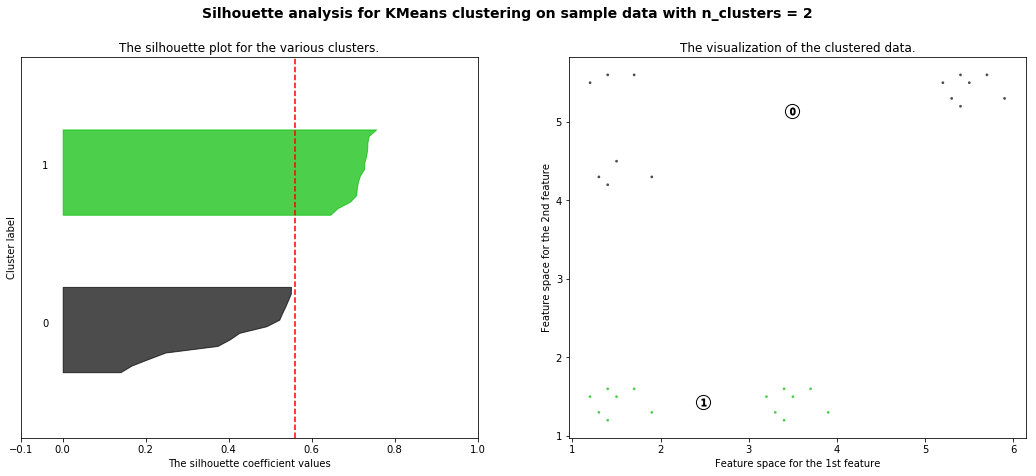

For n_clusters = 3 The average silhouette_score is : 0.7438233041408474


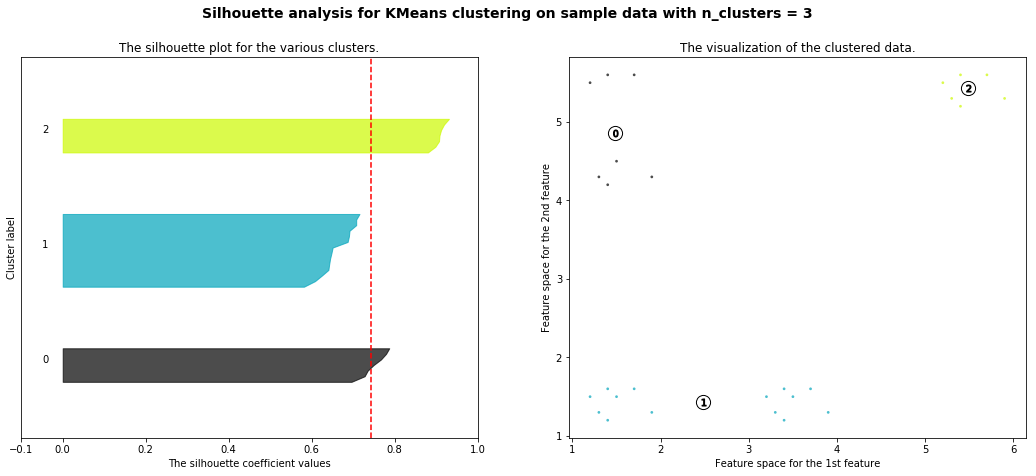

For n_clusters = 4 The average silhouette_score is : 0.8141077603196566


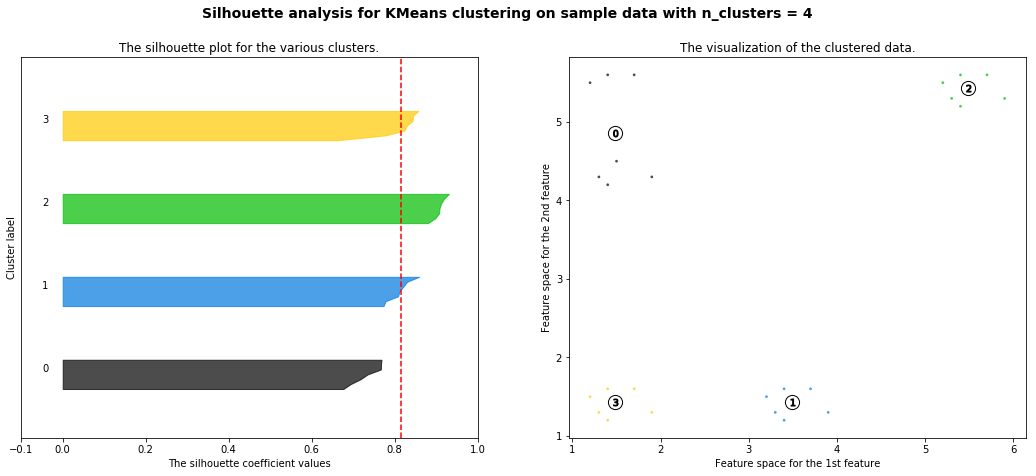

For n_clusters = 5 The average silhouette_score is : 0.8092962577804829


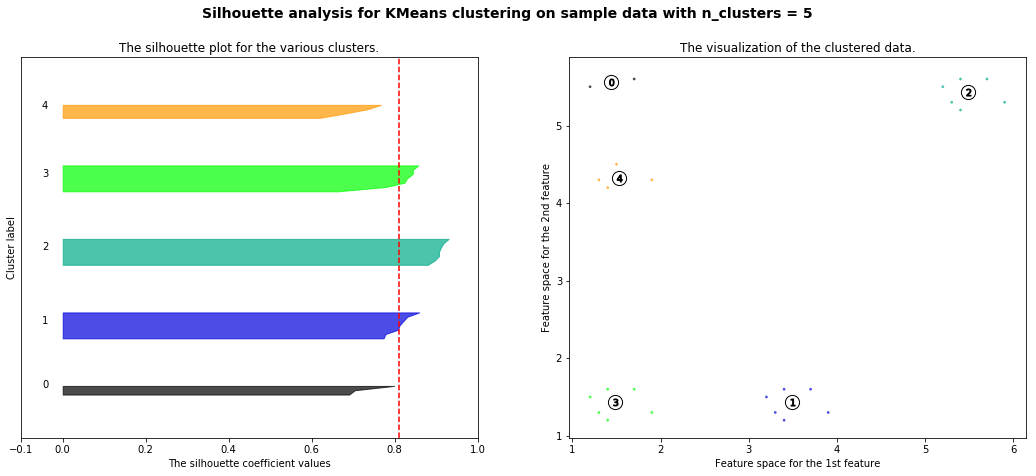

For n_clusters = 6 The average silhouette_score is : 0.696105732430314


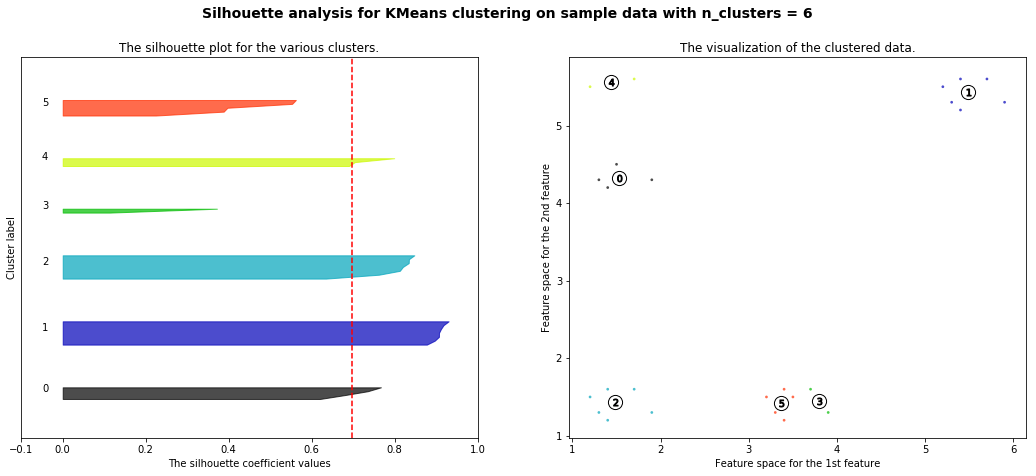

For n_clusters = 7 The average silhouette_score is : 0.5912895564867305


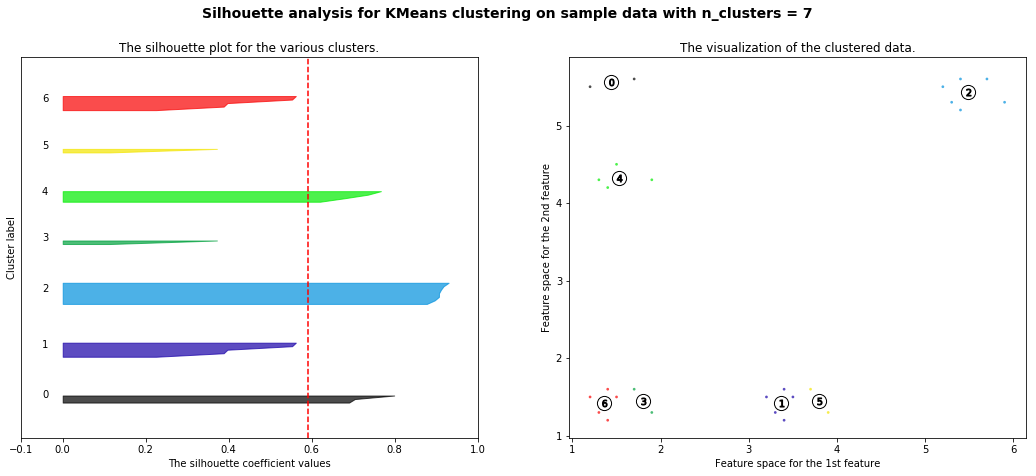

In [14]:
for k in range_n_clusters: grafico_silueta(dataset,k)

Como se puede observar, el valor de silueta más alto se obtiene con k=4, seguido muy de cerca por k=5. Por lo tanto estos son los valores óptimos.  